In [26]:
import torch
import torchvision
import numpy as np
from model.Unet import UNet
from dataset.PetDataset import OxfordIIITPetsAugmented
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import os
from matplotlib import pyplot as plt
from PIL import Image

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
pets_path_test = os.path.join('OxfordPets', 'test')

pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", 
                                                    download=False)

def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_test_loader = DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))

In [29]:
model = UNet().to(device)
model.load_state_dict(torch.load("./res/weights/cp_20240212-224019_e29.pth"))

<All keys matched successfully>

Text(0.5, 1.0, 'Predicted Labels')

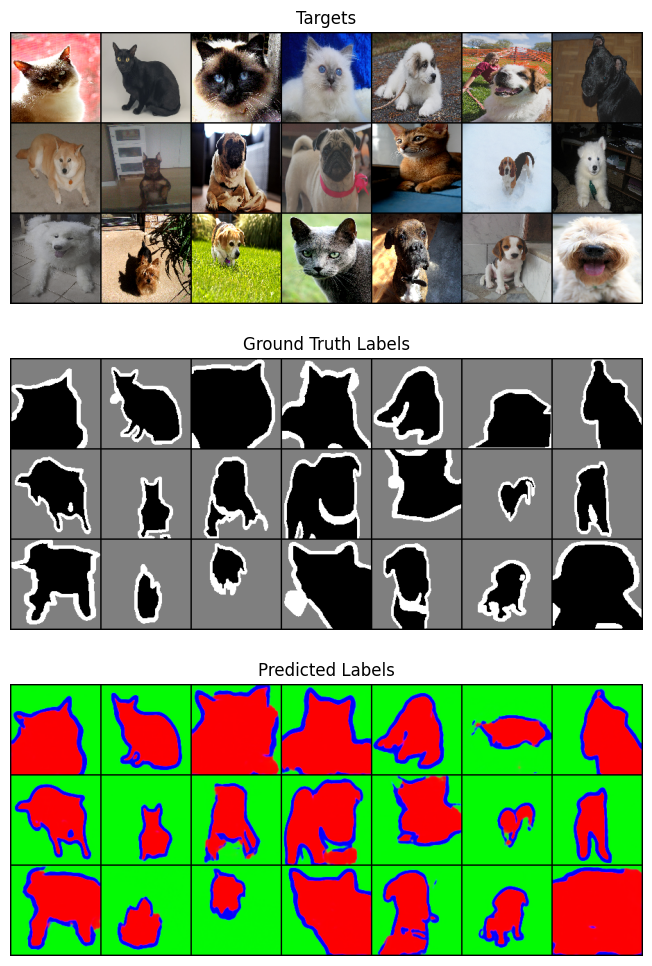

In [30]:
t2img = T.ToPILImage()
model.eval()

predictions = model(test_pets_inputs) 

fig = plt.figure(figsize=(10, 12))

fig.add_subplot(3, 1, 1)
plt.imshow(t2img(torchvision.utils.make_grid(test_pets_inputs, nrow=7)))
plt.axis('off')
plt.title("Targets")

fig.add_subplot(3, 1, 2)
plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets.float()/ 2.0, nrow=7)))
plt.axis('off')
plt.title("Ground Truth Labels")

fig.add_subplot(3, 1, 3)
plt.imshow(t2img(torchvision.utils.make_grid(predictions, nrow=7)))
plt.axis('off')
plt.title("Predicted Labels")

(-0.5, 127.5, 127.5, -0.5)

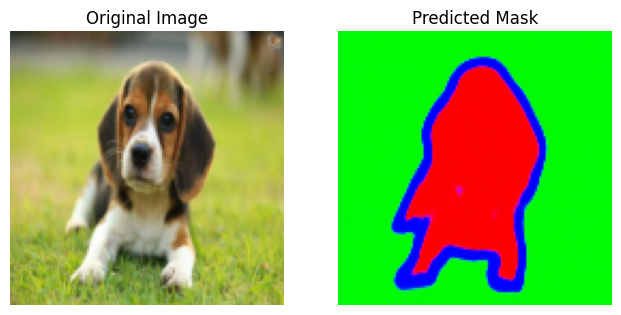

In [31]:
img = "./Immagini/Cane.png"
img = Image.open(img).convert('RGB')
resize = T.Resize((128, 128))
img = resize(img)
img = TF.to_tensor(img)
t2img = T.ToPILImage()
img = img.unsqueeze(0)
pred = model(img)
pred = pred.squeeze()

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(t2img(pred))
plt.title('Predicted Mask')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

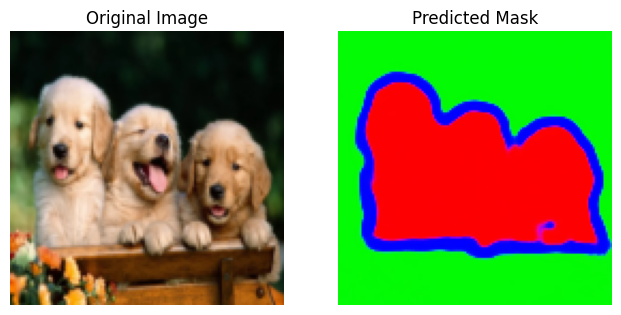

In [32]:
img = "./Immagini/cuccioli_cane.png"
img = Image.open(img).convert('RGB')
resize = T.Resize((128, 128))
img = resize(img)
img = TF.to_tensor(img)
t2img = T.ToPILImage()
img = img.unsqueeze(0)
pred = model(img)
pred = pred.squeeze()

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(t2img(pred))
plt.title('Predicted Mask')
plt.axis('off')